# Applied Time Series

## Exercise 1.2

<div class="alert alert-block alert-info">

1. download data
2. data pre-treatment   
3. Box-Jerkins #1: identification
4. Box-Jerkins #2: estimation
5. Box-Jerkins #3: diagnostics
6. GARCH - new identification and estimation 
7. Forecast evaluation
8. Extra - seasonality     
</div>

## 1. Download data

In [3]:
# We use the YahooFinance API to download stock prices of the S&P500
#!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

ticker='JPM'
start_date = '2000-01-02'
end_date = '2021-11-20'
stockdata = []
stockdata = yf.download(ticker,start_date,end_date)

[*********************100%***********************]  1 of 1 completed


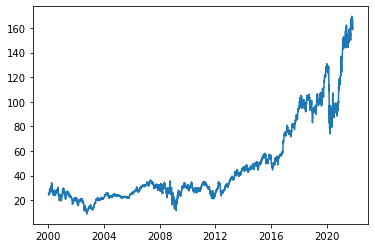

In [4]:
myprice=stockdata.iloc[:,4]
plt.plot(myprice)

## 2. Data pre-treatment

In [5]:
ad_fuller_result1=sm.tsa.stattools.adfuller(myprice, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')

ADF Statistic: -1.0473835401216232
p-value: 0.9373905491016126


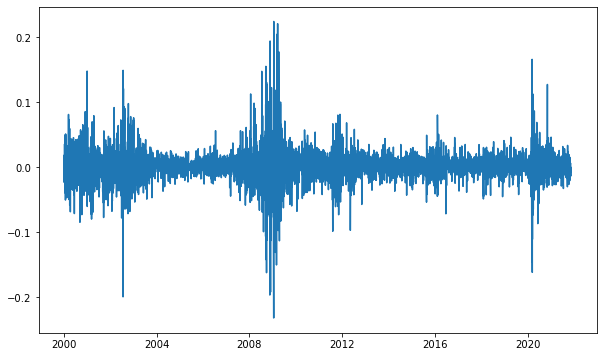

In [6]:
logx=np.log(myprice)
lret=logx.diff()
lret=lret.dropna()
plt.figure(figsize=(10,6))
plt.plot(lret)

In [7]:
ad_fuller_result2=sm.tsa.stattools.adfuller(lret, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')

ADF Statistic: -81.32348581978665
p-value: 0.0


## 3. Box-Jerkins #1: identification

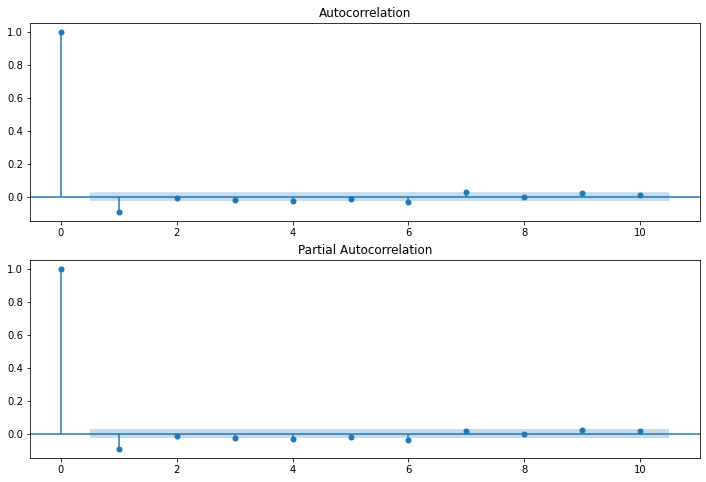

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(lret, lags=10, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(lret, lags=10, ax=ax2)

It is difficult to deduct the p and q order from these plots so we will base the analysis on the information criteria 

In [11]:
from itertools import product
import statsmodels.api as sm
from statsmodels.api import tsa
import warnings
warnings.filterwarnings("ignore")

ar_order = [0, 1, 2]
ma_order = [0, 1, 2]
arma_res = [list(orders) for orders in product(ar_order,ma_order)]

for order in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*order)) 
    try:
        arma_model  = tsa.ARMA(lret*100, order=order).fit(method='mle', disp=-1)
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2
fitting: ar:1 - ma:0
fitting: ar:1 - ma:1
fitting: ar:1 - ma:2
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
fitting: ar:2 - ma:0
fitting: ar:2 - ma:1
fitting: ar:2 - ma:2


In [12]:
res.sort_values(by='bic')

,ar_order,ma_order,aic,bic
1,0,1,25.373579,25.393421
3,1,0,25.374763,25.394605
4,1,1,25.372219,25.398674
2,0,2,25.374892,25.401347
7,2,1,25.368495,25.401563
6,2,0,25.375633,25.402089
8,2,2,25.369607,25.409290
0,0,0,25.418996,25.432223
5,1,2,NaN,NaN


## 4. Box-Jerkins #2: estimation

We estimate the model and apply Engle ARCH test on residuals

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(lret*100, order=(0,0,1))
model_fit = model.fit()
warnings.filterwarnings("ignore")
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5507
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -12683.790
Date:                Fri, 20 May 2022   AIC                          25373.579
Time:                        09:20:44   BIC                          25393.421
Sample:                             0   HQIC                         25380.500
                               - 5507                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0335      0.030      1.116      0.264      -0.025       0.092
ma.L1         -0.0940      0.005    -17.631      0.000      -0.104      -0.084
sigma2         5.8623      0.040    146.324      0.0

## 5. Box-Jerkins #3: diagnostics

In [14]:
res = pd.DataFrame(model_fit.resid)
ad_fuller_result4=sm.tsa.stattools.adfuller(res, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result4[0]}')
print(f'p-value: {ad_fuller_result4[1]}')
critical_value=0.01
if ad_fuller_result4[1]<critical_value:
    print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
else:
    print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")

ADF Statistic: -74.12398780868935
p-value: 0.0
We can reject the null hypothesis of non-stationarity: the TS is stationary


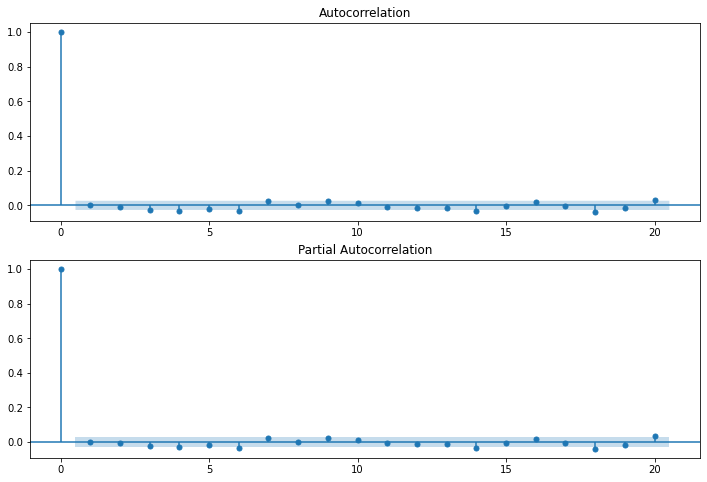

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax2)

In [16]:
res2=res**2
ad_fuller_result5=sm.tsa.stattools.adfuller(res2, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result5[0]}')
print(f'p-value: {ad_fuller_result5[1]}')
critical_value=0.01
if ad_fuller_result5[1]<critical_value:
    print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
else:
    print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")

ADF Statistic: -5.706653228286696
p-value: 8.877946519742186e-06
We can reject the null hypothesis of non-stationarity: the TS is stationary


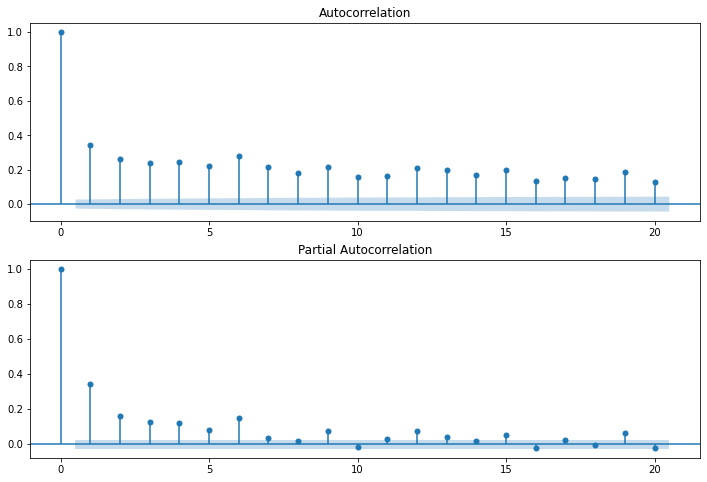

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(res2, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(res2, lags=20, ax=ax2)

We find strong empirical evidence of autocorrelation of residuals

In [18]:
import statsmodels
statsmodels.stats.diagnostic.het_arch(res2)[1] #p-value from Engle ARCH test

1.5309226249050438e-129

The p-value from Engle ARCH test provides statistical evidence of the previous claim

## 6. GARCH - new identification and estimation

In [19]:
from arch import arch_model
am = arch_model(100*lret, p=1, o=0, q=1)
am_fit=am.fit()
am_fit

Iteration:      1,   Func. Count:      6,   Neg. LLF: 39203.91627431299
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12747.861431621819
Iteration:      3,   Func. Count:     22,   Neg. LLF: 2051461142.8758516
Iteration:      4,   Func. Count:     28,   Neg. LLF: 2714231929.142542
Iteration:      5,   Func. Count:     34,   Neg. LLF: 12745.14796944345
Iteration:      6,   Func. Count:     40,   Neg. LLF: 10912.759054673868
Iteration:      7,   Func. Count:     46,   Neg. LLF: 10905.330839696187
Iteration:      8,   Func. Count:     52,   Neg. LLF: 10855.605794759656
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1116723935.351166
Iteration:     10,   Func. Count:     63,   Neg. LLF: 11395.45967383192
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10853.74529029417
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10853.571104637424
Iteration:     13,   Func. Count:     81,   Neg. LLF: 10853.562361183313
Iteration:     14,   Func. Count:     86,   Neg. LLF: 108

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10853.6
Distribution:                  Normal   AIC:                           21715.1
Method:            Maximum Likelihood   BIC:                           21741.6
                                        No. Observations:                 5507
Date:                Fri, May 20 2022   Df Residuals:                     5506
Time:                        09:20:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0812  1.921e-02      4.230  2.339e-05 [4.360e-0

In [20]:
wrap_up=pd.DataFrame(([model_fit.aic, am_fit.aic], 
                              [model_fit.bic, am_fit.bic]),
                    columns=['MA(1)', 'GARCH(1,1)'],
                    index=['aic', 'bic'])
wrap_up=wrap_up.T
wrap_up.sort_values(by='bic')

,aic,bic
"GARCH(1,1)",21715.124630,21741.579731
MA(1),25373.579368,25393.420694


So we prefer a GARCH(1,1) model with constant mean. We do not model the mean because we could only introduce an autoregressive component, but this has shown to be insignificant before. Most of the stock prices volatilities are modeled with a GARCH(1,1) model.

## 7. Forecasts

In [21]:
lret_f=lret[:-20]
am_f = arch_model(100*lret_f, p=1, o=0, q=1)
am_f_fit=am_f.fit()

f_mean=am_f_fit.forecast(horizon=20).mean
f_variance=am_f_fit.forecast(horizon=20).variance

Iteration:      1,   Func. Count:      6,   Neg. LLF: 39163.746694734495
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12708.662032513745
Iteration:      3,   Func. Count:     22,   Neg. LLF: 658802676.3036764
Iteration:      4,   Func. Count:     28,   Neg. LLF: 2732162205.1280117
Iteration:      5,   Func. Count:     34,   Neg. LLF: 12706.727654750357
Iteration:      6,   Func. Count:     40,   Neg. LLF: 10885.664788269194
Iteration:      7,   Func. Count:     46,   Neg. LLF: 10908.865933363342
Iteration:      8,   Func. Count:     52,   Neg. LLF: 10829.35078831379
Iteration:      9,   Func. Count:     58,   Neg. LLF: 11651.225080721437
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10923.773206373151
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10826.195420030668
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10826.187033242291
Iteration:     13,   Func. Count:     81,   Neg. LLF: 10826.186860633043
Iteration:     14,   Func. Count:     86,   Neg. LLF:

In [22]:
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 20)
vol_fcast=np.sqrt(f_variance.iloc[-1])
for i in range(len(vol_fcast)):
    vol_fcast[i]=vol_fcast[i]*s[i]
ret_fcast=f_mean.iloc[-1]+vol_fcast

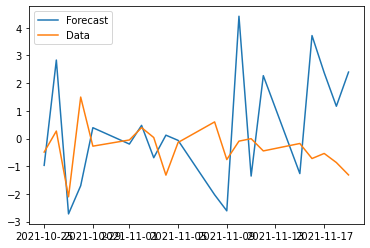

In [24]:
plt.plot(ret_fcast, label='Forecast')
last_ret=lret[-20:]
ret_fcast.index=last_ret.index
plt.plot(last_ret*100, label='Data')
plt.legend()